With class Balancing 

Number of samples after SMOTE: 4618
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
                     Accuracy  Precision    Recall  F1 Score  \
One-Class SVM        0.520480   0.507576  0.549180  0.527559   
Random Forest        0.504496   0.493808  0.653689  0.562610   
K-Nearest Neighbors  0.516484   0.503521  0.586066  0.541667   
Isolation Forest     0.487512   0.487512  1.000000  0.655473   
Gradient Boosting    0.488511   0.484293  0.758197  0.591054   
Logistic Regression  0.489510   0.488465  0.997951  0.655892   
Autoencoder          0.512488   0.500000  0.051230  0.092937   

                     Anomaly Detection %  
One-Class SVM                       0.53  
Random Forest                       0.65  
K-Nearest Neighbors                 0.57  
Isolation Forest                    1.00  
Gradient Boosting                   0.76  
Logistic Regression                 1.00  
Autoencoder                         0.05  


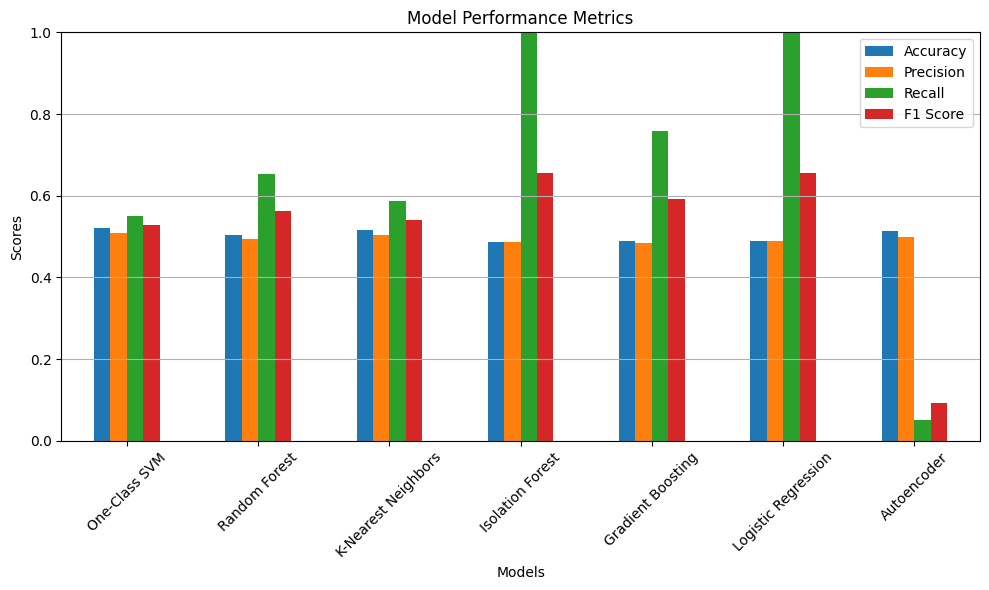

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler
from collections import Counter

data = {
    'hash_rate': [10, 20, 30, 40, 50],  # Example hash rates for nodes
    'malicious_transactions_added': [1, 0, 1, 1, 0],  # From output (1 for True, 0 for False)
    'nodes_after_sybil_attack': [11, 11, 11, 11, 11],  # Fixed value from output
    'nodes_after_eclipse_attack': [1, 1, 1, 1, 1],  # Fixed value from output
    'block_added_after_finney': [1, 0, 1, 1, 0],  # From output (1 for True, 0 for False)
    'transaction_authorized_finney': [0, 1, 0, 1, 0],  # 0 for False, 1 for True
    'blocks_before_attack': [2, 2, 2, 2, 2],  # Fixed value before attack
    'blocks_after_attack': [0, 0, 0, 0, 0],  # Fixed value after attack
    'doc_attack_identified': [1, 1, 1, 0, 0],  # From output (1=Yes, 0=No)
}

df = pd.DataFrame(data)

num_additional_samples = 5000  

def generate_synthetic_data(num_samples):
    synthetic_data = {
        'hash_rate': np.random.randint(5, 100, size=num_samples),
        'malicious_transactions_added': np.random.choice([0, 1], size=num_samples),
        'nodes_after_sybil_attack': np.random.randint(10, 15, size=num_samples),
        'nodes_after_eclipse_attack': np.random.randint(0, 5, size=num_samples),
        'block_added_after_finney': np.random.choice([0, 1], size=num_samples),
        'transaction_authorized_finney': np.random.choice([0, 1], size=num_samples),
        'blocks_before_attack': np.random.randint(1, 5, size=num_samples),
        'blocks_after_attack': np.random.randint(0, 1, size=num_samples),
        'doc_attack_identified': np.random.choice([0, 1], size=num_samples),
    }
    return pd.DataFrame(synthetic_data)

synthetic_df = generate_synthetic_data(num_additional_samples)
df = pd.concat([df, synthetic_df], ignore_index=True)

X = df.drop('doc_attack_identified', axis=1)
y = df['doc_attack_identified']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_counts = Counter(y_train)
desired_minority_samples = target_counts[0] + 500  

smote = SMOTE(random_state=42, sampling_strategy={1: desired_minority_samples})
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

n_samples = X_train_resampled.shape[0]
print(f"Number of samples after SMOTE: {n_samples}")

models = {
    "One-Class SVM": OneClassSVM(),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Isolation Forest": IsolationForest(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.05, n_estimators=150, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Autoencoder": None  
}

def build_autoencoder(input_dim):
    autoencoder = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
        Dense(input_dim, activation='sigmoid')
    ])
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

performance_metrics = {}

for model_name, model in models.items():
    if model_name == "One-Class SVM":
        model.fit(X_train_resampled)
        y_pred = model.predict(X_test)
        y_pred = (y_pred == -1).astype(int)
        anomaly_percentage = np.mean(y_pred)
    elif model_name == "Isolation Forest":
        model.fit(X_train_resampled)
        y_pred = model.predict(X_test)
        y_pred = (y_pred == -1).astype(int)
        anomaly_percentage = np.mean(y_pred)
    elif model_name == "Autoencoder":
        autoencoder = build_autoencoder(X_train_resampled.shape[1])
        autoencoder.fit(X_train_resampled, X_train_resampled, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
        reconstructions = autoencoder.predict(X_test)
        loss = np.mean(np.square(X_test - reconstructions), axis=1)
        threshold = np.percentile(loss, 95)
        y_pred = (loss > threshold).astype(int)
        anomaly_percentage = np.mean(y_pred)
    else:
        model.fit(X_train_resampled, y_train_resampled)
        y_pred = model.predict(X_test)
        anomaly_percentage = np.mean(y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)

    performance_metrics[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Anomaly Detection %": round(anomaly_percentage, 2)
    }

metrics_df = pd.DataFrame(performance_metrics).T

print(metrics_df)

metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Metrics')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Without Class Balancing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
                     Accuracy  Precision  Recall  F1 Score  \
One-Class SVM             1.0        1.0     1.0       1.0   
Random Forest             1.0        1.0     1.0       1.0   
K-Nearest Neighbors       0.0        0.5     0.5       0.0   
Isolation Forest          1.0        1.0     1.0       1.0   
Gradient Boosting         1.0        1.0     1.0       1.0   
Logistic Regression       0.0        0.5     0.5       0.0   
Autoencoder               1.0        1.0     1.0       1.0   

                     Anomaly Detection %  
One-Class SVM                        1.0  
Random Forest                        1.0  
K-Nearest Neighbors                  0.0  
Isolation Forest                     1.0  
Gradient Boosting                    1.0  
Logistic Regression                  0.0  
Autoencoder                          1.0  


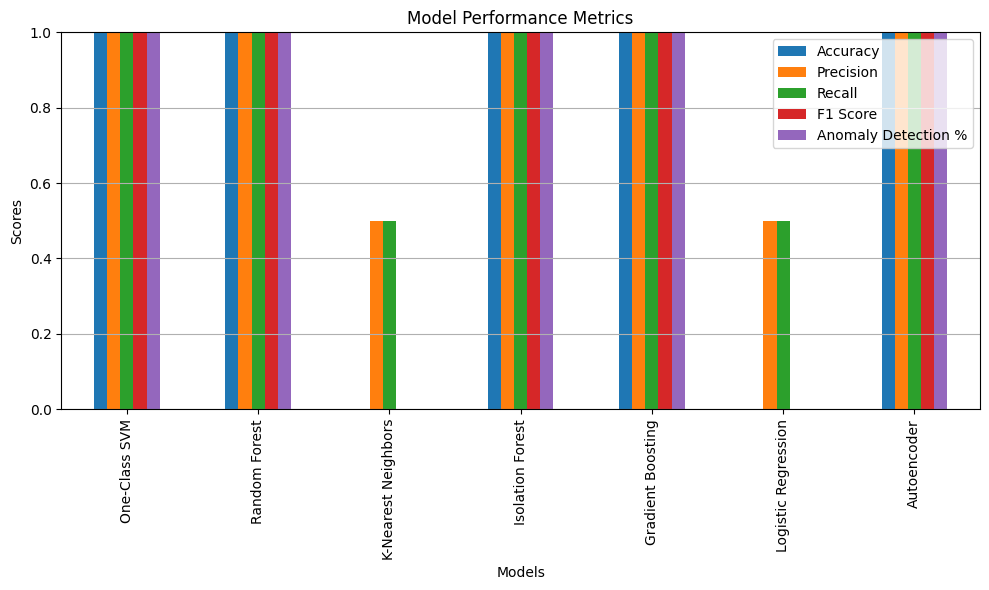

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler

data = {
    'hash_rate': [10, 20, 30, 40, 50],
    'malicious_transactions_added': [1, 0, 1, 1, 0],
    'nodes_after_sybil_attack': [11, 11, 11, 11, 11],
    'nodes_after_eclipse_attack': [1, 1, 1, 1, 1],
    'block_added_after_finney': [1, 0, 1, 1, 0],
    'transaction_authorized_finney': [0, 1, 0, 1, 0],
    'blocks_before_attack': [2, 2, 2, 2, 2],
    'blocks_after_attack': [0, 0, 0, 0, 0],
    'doc_attack_identified': [1, 1, 1, 0, 0],
}

df = pd.DataFrame(data)

X = df.drop('doc_attack_identified', axis=1)
y = df['doc_attack_identified']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

selector = VarianceThreshold(threshold=0.01)
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    "One-Class SVM": OneClassSVM(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=min(3, len(X_train))),
    "Isolation Forest": IsolationForest(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.05, n_estimators=150, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Autoencoder": None,
}


rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None]}
cv_splits = min(5, np.min(np.bincount(y_train)))
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, scoring='f1_macro', cv=cv_splits)

rf_grid.fit(X_train, y_train)
models['Random Forest'] = rf_grid.best_estimator_


def build_autoencoder(input_dim):
    autoencoder = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
        Dense(input_dim, activation='sigmoid')
    ])
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

performance_metrics = {}

for model_name, model in models.items():
    if model_name == "Autoencoder":
        autoencoder = build_autoencoder(X_train.shape[1])
        autoencoder.fit(X_train, X_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)
        reconstructions = autoencoder.predict(X_test)
        loss = np.mean(np.square(X_test - reconstructions), axis=1)
        validation_losses = np.mean(np.square(X_train - autoencoder.predict(X_train)), axis=1)
        threshold = np.percentile(validation_losses, 90)
        y_pred = (loss > threshold).astype(int)
        anomaly_percentage = np.mean(loss > threshold)
    elif model_name in ["One-Class SVM", "Isolation Forest"]:
        model.fit(X_train)
        y_pred = model.predict(X_test)
        y_pred = (y_pred == -1).astype(int)
        anomaly_percentage = np.mean(y_pred)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        anomaly_percentage = np.mean(y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)

    performance_metrics[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Anomaly Detection %": round(anomaly_percentage, 2),
    }

metrics_df = pd.DataFrame(performance_metrics).T
print(metrics_df)

metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Metrics")
plt.ylabel("Scores")
plt.xlabel("Models")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
